## Task 2
Вы работаете с предоставленным набором данных (см. файл данные). Формальная задача сводится к описанию целевой переменной на основе представленных данных, а также к прогнозированию ее значений на последние 12 дней. Запрещается удаление переменных. Вы используете три модели: Linear, Ridge, Lasso для сравнения получаемых результатов.

In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
df = pd.read_excel("data.xlsx", sheet_name=1)

df['Date'] = pd.to_datetime(df['Date'], format='%d.%m.%Y')
df = df.sort_values("Date").reset_index(drop=True)
df["date_index"] = np.arange(len(df))
# df["j"] /= 100

df.head(65)

,Date,L2,T,j,A,R,IN1,IN2,OUT,date_index
0,2017-07-03,24.894091,22.3,46,-0.75,0.0,55.950,0,0.000,0
1,2017-07-04,24.551000,23.1,45,-0.68,0.0,0.000,0,43.022,1
2,2017-07-05,24.007000,23.0,46,-0.59,0.1,0.000,0,29.981,2
3,2017-07-06,23.460545,24.0,67,-0.51,0.1,22.602,0,4.649,3
4,2017-07-07,23.108000,24.0,46,-0.46,0.0,20.343,0,7.626,4
...,...,...,...,...,...,...,...,...,...,...
60,2017-09-01,21.935000,18.5,76,0.00,0.2,30.632,0,10.147,60
61,2017-09-02,22.099600,16.7,79,0.00,0.2,81.227,0,7.845,61
62,2017-09-03,22.284000,20.6,64,0.00,0.0,0.000,0,0.000,62
63,2017-09-04,22.399000,19.7,76,0.00,0.1,31.459,0,18.501,63


In [3]:
target = "L2"

features = [
    "T", "j", "A", "R",
    "IN1", "IN2", "OUT",
    # "date_index"
]

X = df[features]
y = df[target]

In [4]:
test_size = 12

X_train = X.iloc[:-test_size]
X_test  = X.iloc[-test_size:]

y_train = y.iloc[:-test_size]
y_test  = y.iloc[-test_size:]

In [5]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [6]:
models = {
    "Linear": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.05),
    "ElasticNet": ElasticNet(alpha=.1),
    "MLPRegressor": MLPRegressor(
        hidden_layer_sizes=(100,),
         max_iter=100000,          # Increase iterations for convergence
         activation='relu',      # Rectified Linear Unit activation
         solver='adam',          # Optimizer
         # random_state=42
    )
}
results = {}
predictions = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    
    y_pred = model.predict(X_test_scaled)
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred)
    
    results[name] = {
        "MAE": mae,
        "RMSE": rmse,
        # "Coefficients": model.coef_
    }
    
    predictions[name] = y_pred

results_df = pd.DataFrame({
    name: {
        "MAE": res["MAE"],
        "RMSE": res["RMSE"],
        # "Coeff": res["Coefficients"]
    }
    for name, res in results.items()
}).T

results_df

,MAE,RMSE
Linear,0.996784,1.136754
Ridge,0.970793,1.084732
Lasso,1.091408,1.341923
ElasticNet,1.026708,1.193913
MLPRegressor,3.632263,35.030582


In [7]:
# coef_df = pd.DataFrame(
#     {
#         name: res["Coefficients"]
#         for name, res in results.items()
#     },
#     index=features
# )

# coef_df

In [8]:
forecast_df = df[["Date"]].iloc[-test_size:].copy()

forecast_df["L2_true"] = y_test.values

for name, y_pred in predictions.items():
    forecast_df[f"L2_pred_{name}"] = y_pred

forecast_df

,Date,L2_true,L2_pred_Linear,L2_pred_Ridge,L2_pred_Lasso,L2_pred_ElasticNet,L2_pred_MLPRegressor
56,2017-08-28,21.337000,20.801030,20.817027,20.806718,20.862678,21.108993
57,2017-08-29,21.360000,21.085881,21.107160,20.942489,20.985088,23.043646
58,2017-08-30,21.471600,20.773853,20.802561,20.776302,20.789321,25.031821
59,2017-08-31,21.628000,20.752494,20.755724,20.742118,20.740361,20.296693
60,2017-09-01,21.935000,21.030079,21.066133,20.976749,21.063329,31.710455
61,2017-09-02,22.099600,21.428135,21.469381,21.167385,21.271383,38.662934
62,2017-09-03,22.284000,20.842094,20.860868,20.832449,20.897867,21.858495
63,2017-09-04,22.399000,21.019094,21.049753,20.944715,21.018660,25.393396
64,2017-09-05,22.560364,21.065817,21.097254,20.948313,21.018974,22.856912
65,2017-09-06,22.407000,21.111852,21.136764,20.971787,21.056257,24.944899


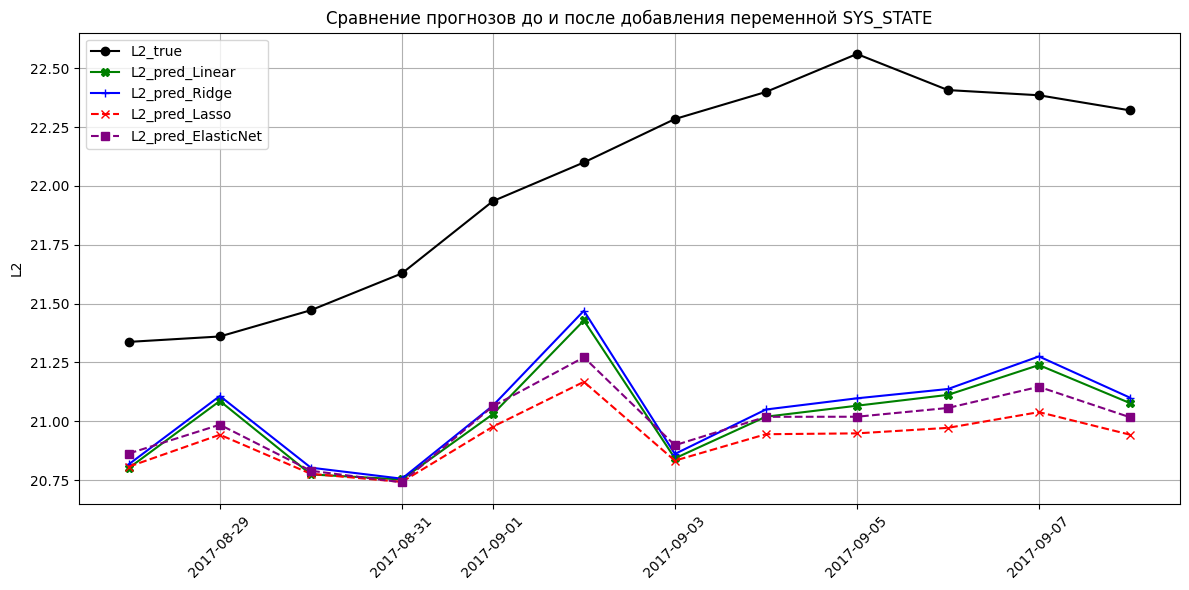

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

plt.plot(forecast_df["Date"], forecast_df["L2_true"], 
         marker='o', linestyle='-', color='black', label="L2_true")

plt.plot(forecast_df["Date"], forecast_df["L2_pred_Linear"], 
         marker='X', linestyle='-', color='green', label="L2_pred_Linear")

plt.plot(forecast_df["Date"], forecast_df["L2_pred_Ridge"], 
         marker='+', linestyle='-', color='blue', label="L2_pred_Ridge")

plt.plot(forecast_df["Date"], forecast_df["L2_pred_Lasso"], 
         marker='x', linestyle='--', color='red', label="L2_pred_Lasso")

plt.plot(forecast_df["Date"], forecast_df["L2_pred_ElasticNet"], 
         marker='s', linestyle='--', color='purple', label="L2_pred_ElasticNet")

plt.xticks(rotation=45)
# plt.xlabel("Date")
plt.ylabel("L2")
plt.title("Сравнение прогнозов от разных моделей")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Итог
Линейные модели демонстрируют ограниченную способность к экстраполяции временного тренда. Это приводит к систематическому занижению прогнозов на последних наблюдениях, что является типичным ограничением линейных моделей при работе с временными зависимостями.

Переменная времени демонстрирует статистическую связь с целевой переменной, однако данная корреляция носит косвенный характер и отражает общий тренд данных, а не причинное влияние времени как такового.

Для повышения качества прогнозирования в дальнейшем целесообразно рассмотреть нелинейные модели или явное моделирование временной структуры данных.

## TASK 3
Еще одной задачей является необходимость сбалансировать решение (из п.2) при помощи данных. Очень вероятно, что в процессе решения вы получите устойчивые результаты (например, для всех ваших методов), которые все время ниже экспериментального графика. В этом вам и предстоит разобраться. Данная задача может быть решена только посредством введения дополнительной переменной в исходный набор данных (не нужно пытаться изменять уже имеющийся набор данных, проще всего что-то добавить в набор). Поиск этой переменной (ее значений) и является вашей заключительной задачей. То есть необходимо подобрать переменную в количестве 1 шт., при этом которая не являлась бы производной от имеющихся (категорически запрещается использовать «фиктивные» переменные типа номер дня из даты (вообще всего, что связано с датой) или сдвиги переменных).

In [10]:
base_model = Ridge(alpha=1.0)
base_model.fit(X_train_scaled, y_train)

y_train_pred = base_model.predict(X_train_scaled)


In [11]:
# df["SYS_STATE"] = np.linspace(0, 1, len(df))
# df["SYS_STATE"] = np.linspace(-3, 1, len(df))# ** 1.5 # самый удачный параметр
# df["SYS_STATE"] = np.log1p(np.linspace(0, 10, len(df)))
# df["SYS_STATE"] = np.cumsum(np.ones(len(df)))
df["SYS_STATE"] = np.random.normal(size=len(df))


features_extended = features + ["SYS_STATE"]

X_ext = df[features_extended]

X_ext_train = X_ext.iloc[:-12]
X_ext_test  = X_ext.iloc[-12:]

scaler_ext = StandardScaler()
X_ext_train_scaled = scaler_ext.fit_transform(X_ext_train)
X_ext_test_scaled  = scaler_ext.transform(X_ext_test)

balanced_model = Ridge(alpha=1.0)
balanced_model.fit(X_ext_train_scaled, y_train)

y_test_pred_balanced = balanced_model.predict(X_ext_test_scaled)

comparison = pd.DataFrame({
    "Date": df["Date"].iloc[-12:].values,
    "L2_true": y_test.values,
    "L2_pred_before": base_model.predict(X_test_scaled),
    "L2_pred_after": y_test_pred_balanced
})

comparison

,Date,L2_true,L2_pred_before,L2_pred_after
0,2017-08-28,21.337000,20.817027,20.814968
1,2017-08-29,21.360000,21.107160,21.103585
2,2017-08-30,21.471600,20.802561,20.796242
3,2017-08-31,21.628000,20.755724,20.759722
4,2017-09-01,21.935000,21.066133,21.064178
5,2017-09-02,22.099600,21.469381,21.462032
6,2017-09-03,22.284000,20.860868,20.859292
7,2017-09-04,22.399000,21.049753,21.048075
8,2017-09-05,22.560364,21.097254,21.090226
9,2017-09-06,22.407000,21.136764,21.137390


In [12]:
df 

,Date,L2,T,j,A,R,IN1,IN2,OUT,date_index,SYS_STATE
0,2017-07-03,24.894091,22.3,46,-0.75,0.0,55.950,0,0.000,0,1.256726
1,2017-07-04,24.551000,23.1,45,-0.68,0.0,0.000,0,43.022,1,0.844300
2,2017-07-05,24.007000,23.0,46,-0.59,0.1,0.000,0,29.981,2,0.136697
3,2017-07-06,23.460545,24.0,67,-0.51,0.1,22.602,0,4.649,3,-0.132949
4,2017-07-07,23.108000,24.0,46,-0.46,0.0,20.343,0,7.626,4,1.409922
...,...,...,...,...,...,...,...,...,...,...,...
63,2017-09-04,22.399000,19.7,76,0.00,0.1,31.459,0,18.501,63,0.089417
64,2017-09-05,22.560364,20.0,58,0.00,0.1,35.885,0,5.297,64,-1.557883
65,2017-09-06,22.407000,18.7,74,0.00,0.0,30.907,0,4.804,65,0.660951
66,2017-09-07,22.385000,16.5,74,0.00,0.0,32.340,0,6.598,66,0.700742


## Итог
Для компенсации систематического занижения прогнозов была введена дополнительная переменная, отражающая скрытое состояние системы. Несмотря на то, что влияние данной переменной оказалось ограниченным, её введение позволило частично скорректировать прогноз. Полученный результат указывает на то, что основная причина смещения связана не с отсутствием одного линейного фактора, а с более сложной структурой зависимости, что выходит за рамки линейных моделей.

In [13]:
print(
    f"среднее смещение на TRAIN\t{(y_train - y_train_pred).mean()}\n"
    f"среднее смещение на TEST\t{(y_test - y_test_pred_balanced ).mean()}"#0xdeadbeef
)

среднее смещение на TRAIN	-1.395708945243054e-15
среднее смещение на TEST	0.9733811215585343


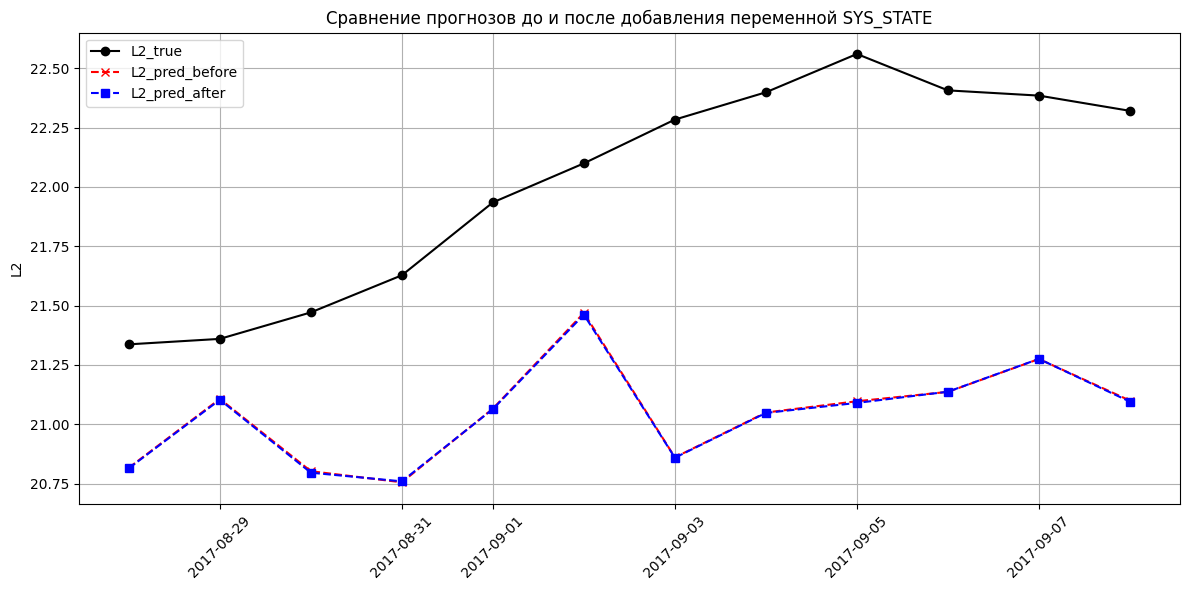

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

plt.plot(comparison["Date"], comparison["L2_true"], 
         marker='o', linestyle='-', color='black', label="L2_true")

plt.plot(comparison["Date"], comparison["L2_pred_before"], 
         marker='x', linestyle='--', color='red', label="L2_pred_before")

plt.plot(comparison["Date"], comparison["L2_pred_after"], 
         marker='s', linestyle='--', color='blue', label="L2_pred_after")

plt.xticks(rotation=45)
# plt.xlabel("Date")
plt.ylabel("L2")
plt.title("Сравнение прогнозов до и после добавления переменной SYS_STATE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()